In [1]:
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY
%load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)


# TF2 로 Densenet 자체 구현 및 성능 측정 

* 참고 자료 
  * https://www.evernote.com/shard/s193/sh/5cfe5c7f-2695-5c81-5700-9358a7bf1ec7/6150595b1b457c236d49502b9d085cb4
  * https://github.com/okason97/DenseNet-Tensorflow2/blob/master/densenet/densenet.py


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, ZeroPadding2D, Dense, Dropout, Activation, Convolution2D, Reshape
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization

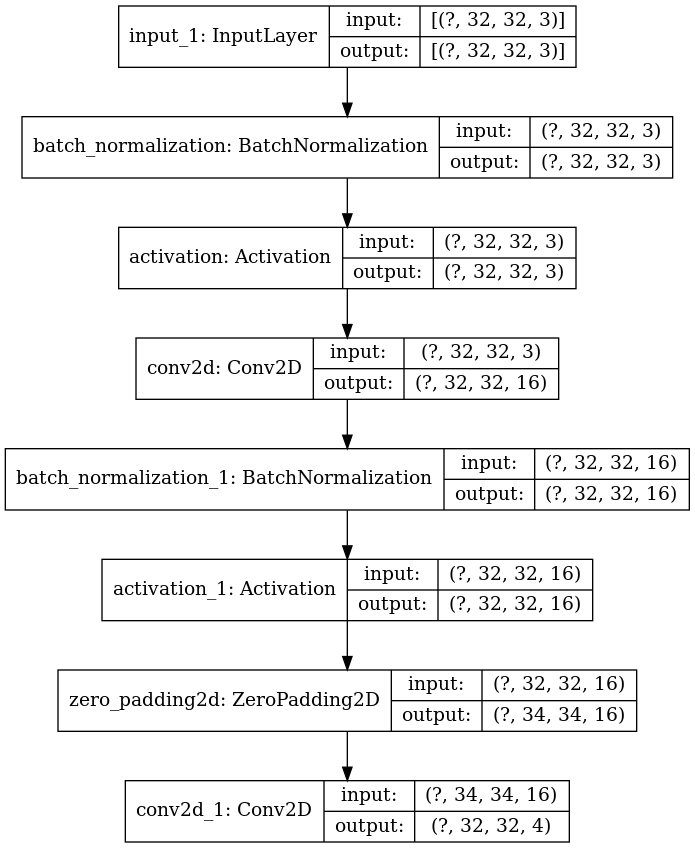

In [7]:
def conv_block(x, filters, dropout_rate=None):

    # 1x1 Convolution (Bottleneck layer) => to 4*filters channel
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(filters * 4, 1, 1, use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(filters, 3, 1, use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

input = Input(shape=(32,32,3))
x = conv_block(input, 4)
conv_model = Model(input,x)
tf.keras.utils.plot_model(conv_model, to_file='model.png', show_shapes=True)

20


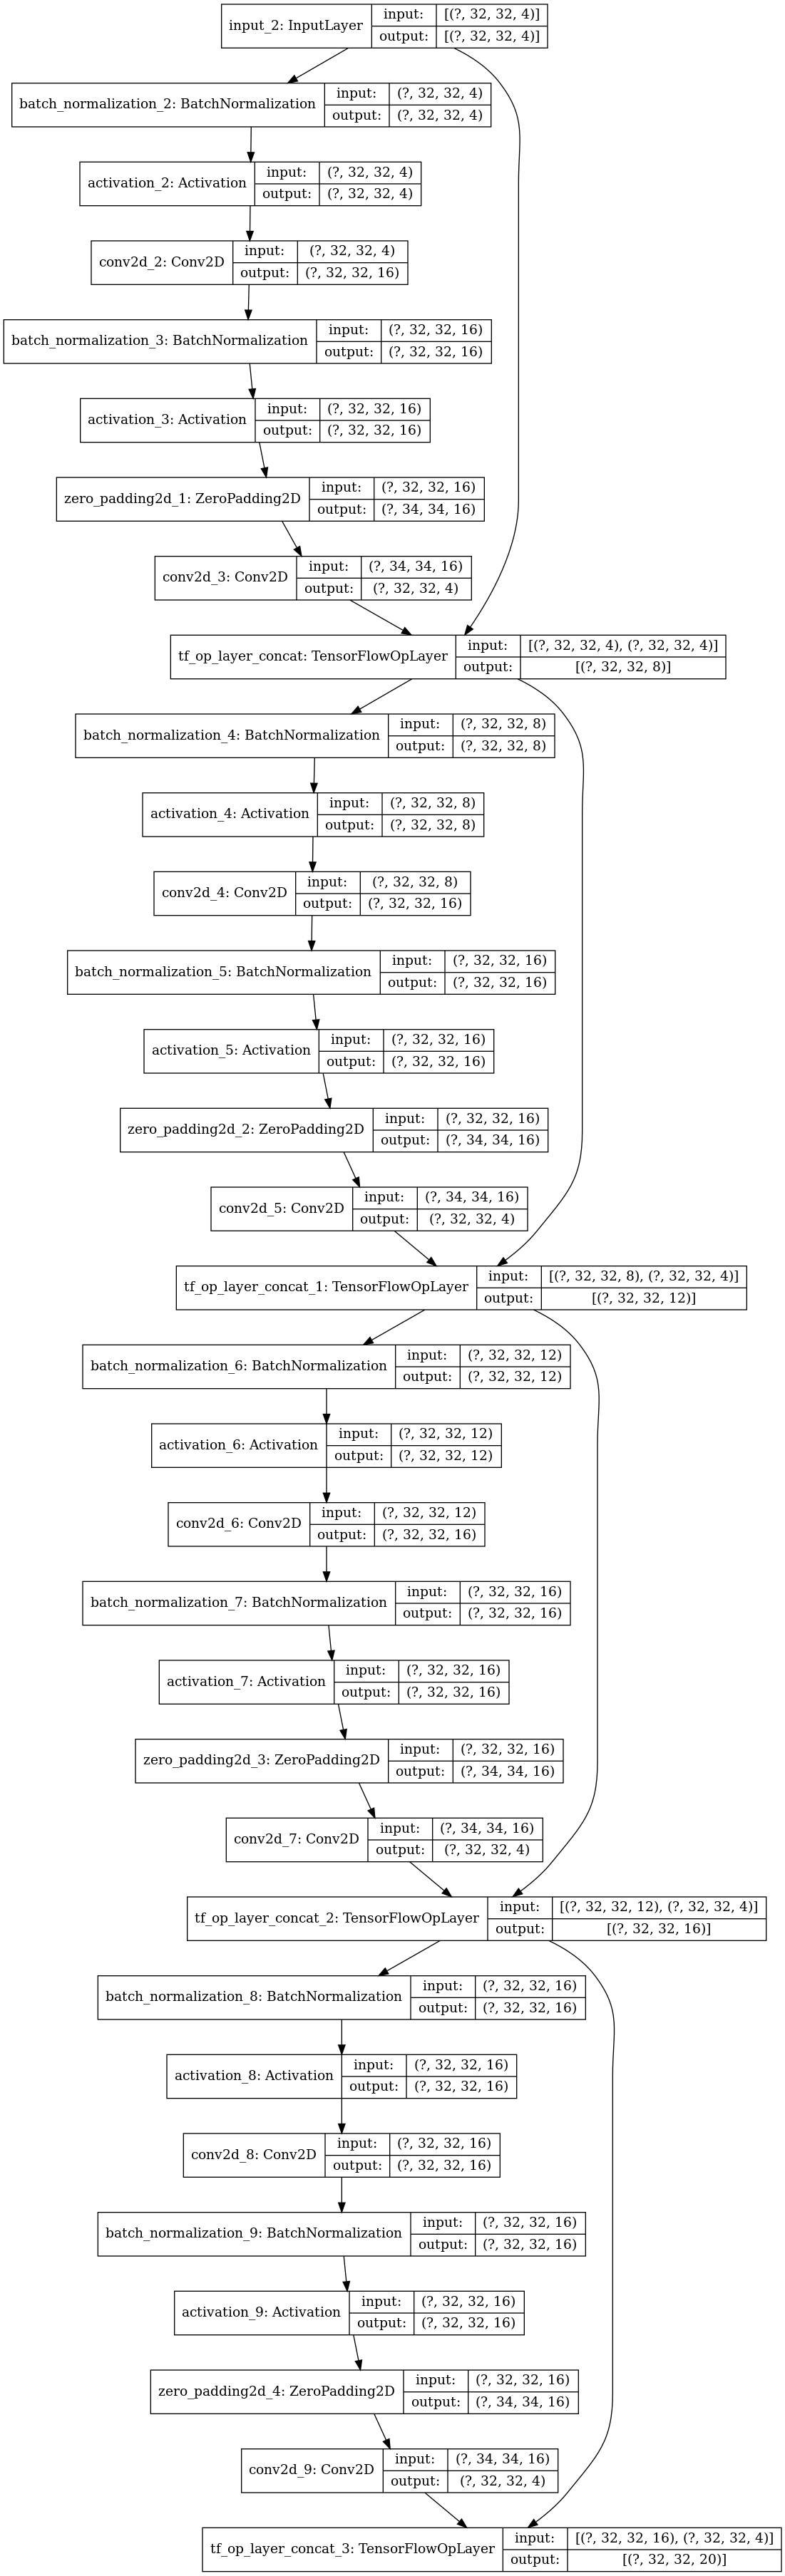

In [8]:
# dense block  
#   out channel = initial_filters + layer * grwoth_rate
def dense_block(x, layers, initial_filters, growth_rate, 
                dropout_rate=None, grow_nb_filters=True):
    
    concat_feat = x
    for i in range(layers):
        x = conv_block(concat_feat, growth_rate, dropout_rate)
        concat_feat = tf.concat([concat_feat, x], -1)  # channel 방향으로 concat

        if grow_nb_filters:
            initial_filters += growth_rate

    # final channel : layers * filters = nb_filter
    
    return concat_feat, initial_filters

input = Input(shape=(32,32,4))
x, filters = dense_block(input, 4, 4, 4, dropout_rate=0.0)
dense_block_model = Model(input,x)
print(filters)
assert filters == 20
tf.keras.utils.plot_model(dense_block_model, to_file='model.png', show_shapes=True)

In [12]:
def se_block(x, nb_filter, ratio = 16):
    init = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(nb_filter // ratio)(x)
    x = Activation('relu')(x)
    x = Dense(nb_filter)(x)
    x = Activation('sigmoid')(x)
    x = tf.expand_dims(x,1)
    x = init * tf.expand_dims(x,1) 
    return x

def transition_block(x, nb_filter, compression=1.0, dropout_rate=None):

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x

def densenet_model(input_shape, growth_rate=32, nb_filter=64, nb_layers = [6,12,24,16], reduction=0.0, 
                   dropout_rate=0.0, classes=16, shape=(32, 32, 3), batch_size=32,
                   with_output_block=True, with_se_layers=True):
    # compute compression factor
    compression = 1.0 - reduction

    nb_dense_block = len(nb_layers)
    # From architecture for ImageNet (Table 1 in the paper)
    # nb_filter = 64
    # nb_layers = [6,12,24,16] # For DenseNet-121
    
    img_input = Input(shape=input_shape, name='data')
    
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding', batch_size=batch_size)(img_input)
    x = Convolution2D(nb_filter, 7, 2, name='conv1', use_bias=False)(x)
    x = BatchNormalization(name='conv1_bn')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)
    
    stage = 0
    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
               
        x, nb_filter = dense_block(x, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate)

        if with_se_layers:
            x = se_block(x, nb_filter)

        # Add transition_block
        x = transition_block(x, nb_filter, compression=compression, dropout_rate=dropout_rate)
        nb_filter = int(nb_filter * compression)

        if with_se_layers:
            x = se_block(x, nb_filter)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate)

    if with_se_layers:
        x = se_block(x, nb_filter)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if not with_output_block:
        return Model(inputs=img_input, outputs=x)

    x = GlobalAveragePooling2D(name='pool_final')(x)
    x = Dense(classes, name='fc6')(x)
    output = Activation('softmax', name='prob')(x)
    
    return Model(inputs=img_input, outputs=output)

model = densenet_model((32,32,3), classes=10)
model.summary()
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 38, 38, 3)    0           data[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

# 학습 

In [13]:
# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

#constant
BATCH_SIZE = 128
EPOCHS = 20
CLASSES = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = tf.keras.optimizers.RMSprop()

log_dir = '/tmp/logs/xception'

# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
# normalize
X_train, X_test = X_train / 255.0, X_test / 255.0
# convert to categorical
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, CLASSES)

# use TensorBoard, princess Aurora!
callbacks = [
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir=log_dir)
]

# train
model.compile(loss='categorical_crossentropy', optimizer=OPTIM,
    metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=BATCH_SIZE,
    epochs=EPOCHS, validation_split=VALIDATION_SPLIT, 
    verbose=VERBOSE, callbacks=callbacks) 
score = model.evaluate(X_test, y_test,
                     batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])


Epoch 1/20
313/313 [==============================] - 22s 70ms/step - loss: 1.6052 - accuracy: 0.4460 - val_loss: 2.0226 - val_accuracy: 0.2360
Epoch 2/20
313/313 [==============================] - 18s 57ms/step - loss: 1.0721 - accuracy: 0.6170 - val_loss: 2.3430 - val_accuracy: 0.3828
Epoch 3/20
313/313 [==============================] - 18s 57ms/step - loss: 0.8733 - accuracy: 0.6966 - val_loss: 2.5878 - val_accuracy: 0.3052
Epoch 4/20
313/313 [==============================] - 18s 57ms/step - loss: 0.7301 - accuracy: 0.7426 - val_loss: 1.5533 - val_accuracy: 0.5255
Epoch 5/20
313/313 [==============================] - 18s 57ms/step - loss: 0.6129 - accuracy: 0.7842 - val_loss: 1.1009 - val_accuracy: 0.6285
Epoch 6/20
313/313 [==============================] - 18s 58ms/step - loss: 0.5190 - accuracy: 0.8173 - val_loss: 1.2514 - val_accuracy: 0.6306
Epoch 7/20
313/313 [==============================] - 18s 58ms/step - loss: 0.4223 - accuracy: 0.8515 - val_loss: 2.4973 - val_accuracy: